In [136]:
import cv2
import numpy as np
import os
from pycocotools import mask as mask_utils
import xml.etree.ElementTree as ET
import pathlib
from PIL import Image
import json
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, label
import random

### Funzioni utili


In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [74]:
categories = [
        {"id": 0, "name": "bicycle"},
        {"id": 1, "name": "horse"},
        {"id": 2, "name": "motorbike"},
        {"id": 3, "name": "diningtable"},
        {"id": 4, "name": "cat"},
        {"id": 5, "name": "aeroplane"},
        {"id": 6, "name": "train"},
        {"id": 7, "name": "dog"},
        {"id": 8, "name": "tvmonitor"},
        {"id": 9, "name": "bird"},
        {"id": 10, "name": "sheep"},
        {"id": 11, "name": "chair"},
        {"id": 12, "name": "sofa"},
        {"id": 13, "name": "person"},
        {"id": 14, "name": "car"},
        {"id": 15, "name": "bottle"},
        {"id": 16, "name": "pottedplant"},
        {"id": 17, "name": "bus"},
        {"id": 18, "name": "cow"},
        {"id": 19, "name": "boat"},
    ]

def id_to_category(id, categories):
    for category in categories:
        if category['id'] == id:
            return category['name']
    return None

a = id_to_category(1, categories)
type(a)

str

In [137]:
import json
import os
import random
import numpy as np
from pycocotools import mask as mask_utils
from typing import Optional
from PIL import Image
from torch.nn.functional import one_hot
import torch
from label_anything.data.coco20i import Coco20iDataset
from safetensors.torch import load_file
from scipy.ndimage import binary_dilation, label

from label_anything.data.utils import AnnFileKeys, BatchKeys, PromptType
from label_anything.data.test import LabelAnythingTestDataset


class VOC5i(Coco20iDataset):
    def _load_safe(self, img_data: dict) -> (torch.Tensor, Optional[torch.Tensor]):  # type: ignore
        """Open a safetensors file and load the embedding and the ground truth.

        Args:
            img_data (dict): A dictionary containing the image data, as in the coco dataset.

        Returns:
            (torch.Tensor, Optional[torch.Tensor]): Returns a tuple containing the embedding and the ground truth.
        """
        assert self.emb_dir is not None, "emb_dir must be provided."
        gt = None

        f = load_file(f"{self.emb_dir}/{str(img_data[AnnFileKeys.ID])}.safetensors")
        embedding = f["embedding"]
        if self.load_gts:
            gt = f[f"{self.name}_gt"]
        return embedding, gt


class PascalVOCTestDataset(LabelAnythingTestDataset):
    num_classes = 20

    def __init__(
        self,
        root: str,
        img_dir: str,
        annotations: str,
        mask_dir_default: str,
        mask_dir_aug: str,
        preprocess=None,
    ):
        super().__init__()
        self.root = root
        self.img_dir = img_dir  # data/raw/VOCdevkit/VOC2012/JPEGImages
        self.annotations = annotations  # trainval_aug.txt
        self.mask_dir = [
            mask_dir_default,
            mask_dir_aug,
        ]  # segmentationClass, segmentationClassAug
        self.preprocess = preprocess  # cose

    def _read_image_ids(self):
        ids = []
        with open(self.annotations) as f:
            for line in f:
                image_path, _ = line.rstrip().split(" ")
                image_id = os.path.splitext(os.path.basename(image_path))[0]
                ids.append(image_id)
        return ids

    def _get_label(self, image_id):
        annotation_file = os.path.join(self.root, "Annotations", image_id + ".xml")
        objects = ET.parse(annotation_file).findall("object")
        labels = []

        for object in objects:
            class_name = object.find("name").text.lower().strip()
            labels.append(class_name)

        return np.array(labels)

    # def _image_to_category(self):
    #     image_to_category = {}
    #     for annotation in self.instances_path["annotations"]:
    #         image_id = annotation["image_id"]
    #         category_id = annotation["category_id"]
    #         image_to_category[image_id] = category_id
    #     return image_to_category

    def __len__(self):
        return len(self._read_image_ids())

    def _get_image(self, image):
        image_path = os.path.join(self.img_dir, image)
        img = Image.open(image_path)
        size = img.size
        if self.preprocess:
            img = self.preprocess(img)  # 3 x h x w
        return img, torch.tensor(size).unsqueeze(0)

    def _select_mask_dir(self):
        return random.sample(self.mask_dir, 2)

    def _get_mask(self, mask_path):
        mask_array = np.array(Image.open(mask_path))
        unique_values = np.unique(mask_array)
        masks = {}

        for value in unique_values:
            if value not in [0, 255]:
                # Apply binary dilation before finding connected components
                dilated_mask = binary_dilation(mask_array == value)
                labeled_array, num_features = label(dilated_mask)
                for i in range(1, num_features + 1):
                    for i in range(1, num_features + 1):
                        mask = np.where(labeled_array == i, 1, 0)
                        rle = mask_utils.encode(
                            np.asfortranarray(mask.astype(np.uint8))
                        )
                        rle["counts"] = rle["counts"].decode(
                            "utf-8"
                        )  # Convert bytes to string
                        rle_mask_key = f"{value}_{i}"
                        masks[rle_mask_key] = rle
        return masks

    def _get_gt(self, mask, labels):
        masks = {}
        for mask_dir in self._select_mask_dir():
            mask_path = os.path.join(mask_dir, mask + ".png")
            if os.path.isfile(mask_path):
                print(mask_path)
                masks = self._get_mask(mask_path)
                break
            else:
                continue
        decoded_masks = {k: mask_utils.decode(v) for k, v in masks.items()}
        print(decoded_masks)
        for k,v in decoded_masks.items():
            self.
            
        if self.preprocess:
            decoded_masks = [
                {k: self.preprocess(v) for k, v in mask.items()}
                for mask in decoded_masks
            ]
        print(decoded_masks)
        return decoded_masks

    def __getitem__(self, idx):
        print(os.path.join(self.img_dir, self._read_image_ids()[idx] + ".jpg"))
        image, size = self._get_image(
            os.path.join(self.img_dir, self._read_image_ids()[idx] + ".jpg")
        )
        gt = self._get_gt(
            self._read_image_ids()[idx],
            self._get_label(self._read_image_ids()[idx]),
        )
        print(image.shape, size, gt)
        return {
            BatchKeys.IMAGES: image,
            BatchKeys.DIMS: size,
        }, gt

In [141]:
from label_anything.data.transforms import CustomNormalize, CustomResize
from torchvision import transforms
annotations = '/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/ImageSets/SegmentationAug/trainval_aug.txt'
img_dir = "/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/JPEGImages"
mask_dir_default = (
    "/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/SegmentationClass"
)
mask_dir_aug = (
    "/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/SegmentationClassAug"
)
root = '/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/'
preprocess = transforms.Compose(
    [
        CustomResize(1024),
        transforms.PILToTensor(),
        CustomNormalize(),
    ]
)
dataset = PascalVOCTestDataset(
    root, 
    img_dir,
    annotations,
    mask_dir_default,
    mask_dir_aug,
    preprocess,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [142]:
print(next(iter(dataloader)))

/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/JPEGImages/2008_006570.jpg
/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/SegmentationClassAug/2008_006570.png
{'15_1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), '15_2': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), '15_3': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), '17_1': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0

AttributeError: 'str' object has no attribute 'items'

In [2]:
def get_items(root, ids):
    images = []
    all_masks = []
    all_labels = []

    for image_id in ids:
        try:
            image = _get_images(root, image_id)
            masks = _get_masks(root, image_id)
            labels = _get_label(root, image_id)
        except Exception as e:
            print(f"Error processing {image_id}: {e}")

        images.append(image)
        all_masks.append(masks)
        all_labels.append(labels)

    return images, all_masks, all_labels


def _read_image_ids(image_sets_file):
    ids = []
    with open(image_sets_file) as f:
        for line in f:
            image_path, _ = line.rstrip().split(" ")
            image_id = os.path.splitext(os.path.basename(image_path))[0]
            ids.append(image_id)
    return ids


def _get_images(root, image_id):
    image_file = os.path.join(root, "JPEGImages", image_id + ".jpg")
    image = cv2.imread(str(image_file))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def _get_masks(root, image_id):
    mask_array = np.array(Image.open(chosen_file))
    unique_values = np.unique(mask_array)
    masks = {}

    for value in unique_values:
        if value not in [0, 255]:
            # Apply binary dilation before finding connected components
            dilated_mask = binary_dilation(mask_array == value)
            labeled_array, num_features = label(dilated_mask)
            for i in range(1, num_features + 1):
                for i in range(1, num_features + 1):
                    mask = np.where(labeled_array == i, 1, 0)
                    rle = mask_utils.encode(np.asfortranarray(mask.astype(np.uint8)))
                    rle["counts"] = rle["counts"].decode(
                        "utf-8"
                    )  # Convert bytes to string
                    rle_mask_key = f"{value}_{i}"
                    masks[rle_mask_key] = rle

    return masks


def _get_label(root, image_id):
    annotation_file = os.path.join(root, "Annotations", image_id + ".xml")
    objects = ET.parse(annotation_file).findall("object")
    labels = []

    for object in objects:
        class_name = object.find("name").text.lower().strip()
        labels.append(class_name)

    return np.array(labels)


# create the ids for images
root = pathlib.Path("/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012")

In [3]:
dataset_file = os.path.join(root, "ImageSets", "SegmentationAug", "trainval_aug.txt")
ids = _read_image_ids(dataset_file)
print(len(ids))

12031


In [4]:
for id in ids:
    image = _get_images(root, id)
    print(image.shape)
    mask = _get_masks(root, id)
    print(mask)
    label = _get_label(root, id)
    print(label)
    

(281, 500, 3)
/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
[  0   1  15 255]
{'1_1': {'size': [281, 500], 'counts': '[cT11f84M2N2N101N100000O010O10000000000003M1O1O1O00O1O1LhGFY8:2011O1O1O1O00000O10O1O1O1O1O10000000O10O100000O0M4O001O1O0O2O000001O2H8I7NoQc2'}, '1_2': {'size': [281, 500], 'counts': 'Xel01g82N2O0000001O1O0000000000000000000000000000000000000000000000000000000000000000000000001O01O00000000000000000001O01O01O000000000001O0000000000000000000000000001O0001O001O000000000001O1OO1`0^O5L3K4N2M3N2N2N1O2N2N2N2QI]Nc60XIm1e65N3N1N200O00000000O1O11O1OO1O0AeI_N^6a1cI]N]6c1eIXNI1b6h1<00O00001O100O1O1O1O2N1M3O2N1O1O1IdHnN_7Q160OC[HGe77\\HIe75\\HKg71ZHOe71\\HOe70\\HNd72]HNb72_HN`73`HLMOV75mHKM2U75lHHO5T74lHG13T77jH6W7JhH4[7LfH4Y7LgH7V7IjH8U7GlHHO5T73mHG14S75lHG22T76jHHh76YHJg75ZHKg70]H0d7N]H2U8000000O1000000000O1000O10000000000000O10000000000000000000000000000000000000000000000000000000000000O001O10000000000000O0100000000000000000O010000000000

TypeError: 'numpy.ndarray' object is not callable

### Generazione items dataset


In [11]:
images, polygons, labels = get_items(root, ids)  # time consuming: 2.46 minuti

/home/emanuele/LabelAnything/data/raw/VOCdevkit/VOC2012/SegmentationClassAug/2007_000032.png
[  0   1  15 255]
Error processing 2007_000032: 'numpy.ndarray' object is not callable


UnboundLocalError: local variable 'masks' referenced before assignment

### JSON Formatting


In [ ]:
instances_voc12 = {
    "info": {
        "description": "VOC 2012 Dataset Annotations files",
        "version": "1.0",
        "year": 2024,
        "contributor": "CILAB",
        "date_created": "02/01/2024",
    },
    "images": [
        # {
        #     "file_name": "2007_000032",
        #     "url": "VOC2012/JPEGImages/2007_000032.jpg",
        #     "height": 281,
        #     "width": 500,
        #     "id": 0,
        # },
        # {...},
    ],
    "annotations": [
        # {
        #     "segmentation": [
        #         [
        #             [117.0, 89.0],
        #             [116.0, 90.0],
        #             [109.0, 90.0],
        #             [107.0, 92.0],
        #             [134.0, 171.0],
        #             [128.0, 171.0],
        #             [127.0, 170.0],
        #             [127.0, 137.0],
        #         ]
        #     ],
        #     "area": 20098.5,
        #     "image_id": 40,
        #     "bbox": [118.0, 176.0, 330.0, 277.0],
        #     "category_id": 9,
        #     "id": 64,
        # },
        # {...},
    ],
    "categories": [
        # {"id": 0, "name": "sheep"},
        # {"id": 1, "name": "bird"},
        # {"id": 2, "name": "bus"},
        # {"id": 3, "name": "cow"},
    ],
}
instances_voc12

{'info': {'description': 'VOC 2012 Dataset Annotations files',
  'version': '1.0',
  'year': 2024,
  'contributor': 'CILAB',
  'date_created': '02/01/2024'},
 'images': [],
 'annotations': [],
 'categories': []}

### Function to create lvis style annotations for voc12


In [ ]:
def create_annotation(ids, images, boxes, rle_masks, labels, annotations):
    # generate set of categories
    annotations_images = []
    annotations_segmentations = []

    annotations_categories = [
        {"id": i, "name": name} for i, name in enumerate(set(np.concatenate(labels)))
    ]
    category_to_id = {
        category["name"]: category["id"] for category in annotations_categories
    }

    for enum, id_ in enumerate(ids):
        # print(ids[i])
        image = {
            "file_name": f"JPEGImages/{id_}.jpg",  # This is the only field that is compulsory
            "coco_url": f"JPEGImages/{id_}.jpg",
            "height": images[enum].shape[0],
            "width": images[enum].shape[1],
            "id": id_,
        }
        annotations_images.append(image)

    i = 0
    for enum, (id_, box, rle, label) in enumerate(zip(ids, boxes, rle_masks, labels)):
        for b, (_, rle_value), l in zip(box, rle.items(), label):
            annotation = {
                "segmentation": rle_value,
                "area": int(mask_utils.area(rle_value)),
                "image_id": id_,
                "bbox": b.tolist(),  # Assuming box is a list/array of [x_min, y_min, x_max, y_max]
                "category_id": category_to_id[l],
                "id": i,
            }
            annotations_segmentations.append(annotation)
            i += 1

    annotations["images"] = annotations_images
    annotations["annotations"] = annotations_segmentations
    annotations["categories"] = annotations_categories
    return annotations

In [6]:
# generate file, if you want to use it in the future
annotations = create_annotation(ids, images, boxes, polygons, labels, instances_voc12)

In [11]:
annotations['categories']

[{'id': 0, 'name': 'aeroplane'},
 {'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'dog'},
 {'id': 3, 'name': 'bicycle'},
 {'id': 4, 'name': 'sheep'},
 {'id': 5, 'name': 'sofa'},
 {'id': 6, 'name': 'horse'},
 {'id': 7, 'name': 'chair'},
 {'id': 8, 'name': 'cow'},
 {'id': 9, 'name': 'cat'},
 {'id': 10, 'name': 'tvmonitor'},
 {'id': 11, 'name': 'bus'},
 {'id': 12, 'name': 'motorbike'},
 {'id': 13, 'name': 'train'},
 {'id': 14, 'name': 'bird'},
 {'id': 15, 'name': 'bottle'},
 {'id': 16, 'name': 'boat'},
 {'id': 17, 'name': 'diningtable'},
 {'id': 18, 'name': 'car'},
 {'id': 19, 'name': 'pottedplant'}]

0 [104.0, 105.0, 272.0, 79.0]


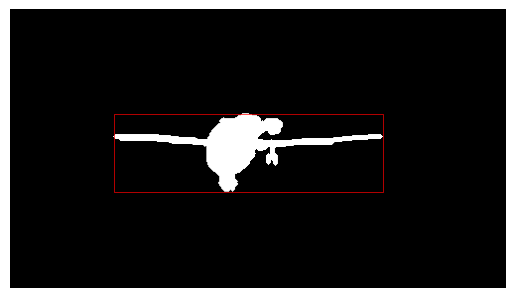

In [10]:
maschera = annotations["annotations"][0]["segmentation"]
label = annotations["annotations"][0]["category_id"]
maschera_array = mask_utils.decode(maschera)

bbox = annotations["annotations"][0]["bbox"]
print(label, bbox)

# Plot della maschera and bbox
plt.imshow(maschera_array, cmap="gray")
plt.gca().add_patch(
    plt.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=0.5,
        edgecolor="r",
        facecolor="none",
    )
)
plt.axis("off")
plt.show()

In [12]:
for k, v in annotations.get("annotations")[0].items():
    print(k, type(v))

segmentation <class 'str'>
area <class 'int'>
image_id <class 'int'>
bbox <class 'list'>
category_id <class 'int'>
id <class 'int'>


### Save file json


In [17]:
with open("instances_voc12.json", "w") as file:
    json.dump(annotations, file)

In [4]:
data = {
    "license": 4,
    "file_name": "000000397133.jpg",
    "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
    "height": 427,
    "width": 640,
    "date_captured": "2013-11-14 17:02:52",
    "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
    "id": 397133,
}
image = {
    "file_name": "2007_000042",
    "url": "JPEGImages/2007_000042.jpg",
    "height": 335,
    "width": 500,
    "id": 3,
}
dataset_path = "/home/emanuele/Dottorato/dataset-vari/VOC12"
(f'{dataset_path}/{image["url"]}')

'/home/emanuele/Dottorato/dataset-vari/VOC12/JPEGImages/2007_000042.jpg'